In [1]:
%matplotlib inline

In [4]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn.apionly as sns
import mirnylib.plotting
mpl.style.use('seaborn-poster')

import numpy as np
import pandas
from scipy.stats import spearmanr
from mirnylib import numutils
import cooler
import bioframe

In [13]:
"""
cis and trans eigenvector decomposition on Hi-C numpy arrays

refactored from mirnylib and hiclib

"""

def _filter_heatmap(A, transmask, perc_top, perc_bottom):
    # Truncate trans blowouts
    lim = np.percentile(A[transmask], perc_top)
    tdata = A[transmask]
    tdata[tdata > lim] = lim
    A[transmask] = tdata

    # Remove bins with poor coverage in trans
    marg = np.sum(A, axis=0)
    marg_nz = marg[np.sum(A, axis=0) > 0]
    min_cutoff = np.percentile(marg_nz, perc_bottom)
    dropmask = (marg > 0) & (marg < min_cutoff)
    idx = np.flatnonzero(dropmask)
    A[idx, :] = 0
    A[:, idx] = 0
    return A


def _fake_cis(A, cismask):
    cismask = cismask.astype(np.int64)
    s = np.abs(np.sum(A, axis=0)) <= 1e-10
    cismask[:, s] = 2
    cismask[s, :] = 2
    numutils.fakeCisImpl(A, cismask)
    return A


def _orient_eigs(lam, vecs, gc):
    # If GC is provided reorder and change signs of E1, E2, etc. by GC 
    # correlation. If not, reorder by descending eigenvalue magnitude and 
    # don't change signs.
    if gc is not None:
        corrs = [spearmanr(gc, vec, nan_policy='omit')[0] for vec in vecs]
        signs = np.sign(corrs)
        idx = np.argsort(-np.abs(corrs))
        lam, vecs, signs = lam[idx], vecs[idx], signs[idx]
        # change signs
        for i in range(len(vecs)):
            vecs[i] = signs[i] * vecs[i]
    else:
        idx = np.argsort(-np.abs(lam))
        lam, vecs = lam[idx], vecs[idx]
    return lam, vecs


def _eig(A, k):
    # Compute eigs
    vecs, lam = numutils.zeroEIG(A, numPCs=k)

    # eigsh returns unit vectors, but just making sure
    # then rescale by sqrt(eigval)
    for j in range(len(lam)):
        vecs[j] /= np.sqrt(np.sum(vecs[j]**2))
        vecs[j] *= np.sqrt(np.abs(lam[j]))

    return lam, np.array(vecs)


def trans_eig(A, partition, k=3, perc_top=99.95, perc_bottom=1, gc=None):
    """
    Compute compartmentalization eigenvectors on trans contact data

    Parameters
    ----------
    A : 2D array
        balanced whole genome contact matrix
    partition : sequence of int
        bin offset of each contiguous region to treat separately (e.g., 
        chromosomes or chromosome arms)
    k : int
        number of eigenvectors to compute; default = 3
    perc_top : float (percentile)
        filter - clip trans blowout contacts above this cutoff; default = 99.95
    perc_bottom : float (percentile)
        filter - remove bins with trans coverage below this cutoff; default=1
    gc : 1D array, optional
        GC content per bin for reordering and orienting the primary compartment 
        eigenvector; not performed if no array is provided

    Returns
    -------
    eigenvalues, eigenvectors

    """
    if A.shape[0] != A.shape[1]:
        raise ValueError("A is not symmetric")
    
    A = np.array(A)
    A[np.isnan(A)] = 0
    n_bins = A.shape[0]
    if not (partition[0] == 0 and 
            partition[-1] == n_bins and 
            np.all(np.diff(partition) > 0)):
        raise ValueError("Not a valid partition. Must be a monotonic sequence "
                         "from 0 to {}.".format(n_bins))

    # Delete cis data and create trans mask
    extents = zip(partition[:-1], partition[1:])
    part_ids = []
    for n, (i0, i1) in enumerate(extents):
        A[i0:i1, i0:i1] = 0
        part_ids.extend([n] * (i1 - i0))
    part_ids = np.array(part_ids)
    transmask = (part_ids[:, None] != part_ids[None, :])

    # Filter heatmap
    A = _filter_heatmap(A, transmask, perc_top, perc_bottom)
    
    # Fake cis and re-balance
    A = _fake_cis(A, ~transmask)
    A = numutils.iterativeCorrection(A)[0]
    A = _fake_cis(A, ~transmask)
    A = numutils.iterativeCorrection(A)[0]
    
    # Compute eig
    Abar = A.mean()
    O = (A - Abar) / Abar
    lam, vecs = _eig(O, k)
    lam, vecs = _orient_eigs(lam, vecs, gc)
    
    return lam, vecs


def cis_eig(A, k=3, robust=True, gc=None, classic=False):
    """
    Compute compartment eigenvector on a cis matrix

    Parameters
    ----------
    A : 2D array
        balanced whole genome contact matrix
    k : int
        number of eigenvectors to compute; default = 3
    robust : bool
        Clip top 0.1 percentile and smooth first two diagonals
    gc : 1D array, optional
        GC content per bin for choosing and orienting the primary compartment 
        eigenvector; not performed if no array is provided
    classic : bool
        Do it old-school

    Returns
    -------
    eigenvalues, eigenvectors

    """
    A = np.array(A)
    A[~np.isfinite(A)] = 0
    
    mask = A.sum(axis=0) > 0

    if A.shape[0] <= 5 or mask.sum() <= 5:
        return (
            np.array([np.ones(A.shape[0]) * np.nan for i in range(k)]),
            np.array([np.nan for i in range(k)]),
        )

    if robust:
        A = np.clip(A, 0, np.percentile(A, 99.9))
        fill_value = np.mean(np.diag(A, 2) * 2) 
        for d in [-1, 0, 1]:
            numutils.fillDiagonal(A, fill_value, d) 
            A[~mask, :] = 0
            A[:, ~mask] = 0

    OE = numutils.observedOverExpected(A[mask, :][:, mask])

    if robust:
        OE = np.clip(OE, 0, np.percentile(OE, 99.9))

    if classic:
        OE = numutils.iterativeCorrection(OE)[0]
        if (~np.isfinite(OE)).sum() > 0:
            return (
                np.array([np.ones(A.shape[0]) * np.nan for i in range(k)]),
                np.array([np.nan for i in range(k)]),
            )
        # mean-centered (subtract mean)
        eigvecs_compressed, eigvals = numutils.EIG(OE, k)
    else:
        eigvecs_compressed, eigvals = numutils.EIG((OE - 1.0), k, 
            subtractMean=False, divideByMean=False)
    
    # Restore full eigs
    eigvecs = []
    for i in range(k):
        v = np.ones(mask.shape[0]) * np.nan
        v[mask] = eigvecs_compressed[i]
        eigvecs.append(v)
    eigvecs = np.array(eigvecs)

    # Orient and reorder
    eigvals, eigvecs = _orient_eigs(eigvals, eigvecs, gc)

    return eigvals, eigvecs


def cooler_cis_eigs(clr, bins, gc_col='GC', **kwargs):
    bins_grouped = bins.groupby('chrom')
    def _each(chrom):
        A = clr.matrix(balance=True).fetch(chrom)
        gc = None
        if gc_col in bins:
            gc = bins_grouped.get_group(chrom)[gc_col].values
        
        lam, vec = cis_eig(A, robust=True, gc=gc, **kwargs)
        
        eig = bins_grouped.get_group(chrom).copy()
        for i in range(len(vec)):
            eig['E{}'.format(i+1)] = vec[i]
        
        return lam, eig
    
    bins_chroms = list(bins_grouped.groups.keys())
    map_chroms = [chrom for chrom in clr.chromnames if chrom in bins_chroms]

    lams, vecs = zip(*map(_each, map_chroms))
    lams = pandas.DataFrame(
        index=map_chroms,
        data=np.vstack(lams),
        columns=['lam1', 'lam2', 'lam3'],
    )
    lams.index.name = 'chrom'
    vecs = pandas.concat(vecs, axis=0, ignore_index=True)
    return lams, vecs


def cooler_trans_eig(clr, bins, partition=None, gc_col='GC', **kwargs):

    if partition is None:
        partition = np.r_[ 
            [clr.offset(chrom) for chrom in clr.chromnames], len(clr.bins())]
    
    lo = partition[0]
    hi = partition[-1]
    A = clr.matrix(balance=True)[lo:hi, lo:hi]

    gc = None
    if gc_col in bins:
        gc = bins[gc_col].values
    lam, PCs = trans_eig(A, partition, gc=gc, **kwargs)

    vecs = bins.copy()
    for i in range(len(PCs)):
        vecs['E{}'.format(i+1)] = PCs[i]

    return lam, vecs


In [8]:
fasta_records = bioframe.read_fasta('data/mm9.fa.gz')
chromsizes = cooler.util.fetch_chromsizes('mm9')[:'chr19']
chromosomes = list(chromsizes.index)
binsize = 100000
bins = cooler.binnify(chromsizes, binsize)
bins.head()

,chrom,start,end
0,chr1,0,100000
1,chr1,100000,200000
2,chr1,200000,300000
3,chr1,300000,400000
4,chr1,400000,500000


In [9]:
bins['GC'] = bioframe.tools.frac_gc(bins, fasta_records)
bins.head()

,chrom,start,end,GC
0,chr1,0,100000,NaN
1,chr1,100000,200000,NaN
2,chr1,200000,300000,NaN
3,chr1,300000,400000,NaN
4,chr1,400000,500000,NaN


In [10]:
pal = sns.color_palette('muted')
colors = {
    'U': pal[1],
    'T': pal[0],
    'N': pal[2]
}

clrs = {
    'U': cooler.Cooler(f'data/UNTR.{binsize}.cool'),#f'/net/levsha/share/nezar/TCCSpitz2015_distiller/output/coolers/library_group/UNTR.{binsize}.cool'),
    'T': cooler.Cooler(f'data/TAM.{binsize}.cool'),
    'N': cooler.Cooler(f'data/NIPBL.{binsize}.cool'),
}

In [15]:
lam = {}
vec = {}
for cond in ['U', 'T', 'N']:
    lam[cond], vec[cond] = cooler_cis_eigs(clrs[cond], bins, gc_col='GC')

eigenvalues are: [ 330.34817976  339.64614528  861.33220653]
eigenvalues are: [ 355.50484234  409.6986118   908.45224054]
eigenvalues are: [-235.57713831  315.68023411  608.47319351]
eigenvalues are: [-311.46913899  420.52139626  795.04473462]
eigenvalues are: [-356.43734207  441.50140299  769.78904077]
eigenvalues are: [ 241.28011534  299.557626    702.46528745]
eigenvalues are: [ 220.66064478  274.00342121  591.53559134]
eigenvalues are: [-204.73406117  232.9533683   591.07596555]
eigenvalues are: [-249.29002234  254.12651031  586.42898621]
eigenvalues are: [ 190.95496546  215.82917896  568.31190817]
eigenvalues are: [-269.40438287  320.06544787  634.37065826]
eigenvalues are: [-209.51931013  254.58591596  590.61344237]
eigenvalues are: [ 197.74007935  230.82594172  527.63388981]
eigenvalues are: [-220.7863243   263.58052087  525.57291197]
eigenvalues are: [-208.19029176  251.80481052  524.86260499]
eigenvalues are: [-185.69824281  205.40515402  423.72068803]
eigenvalues are: [-141.9

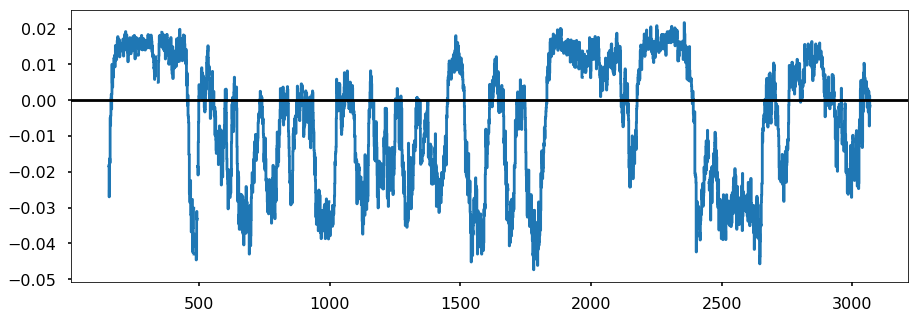

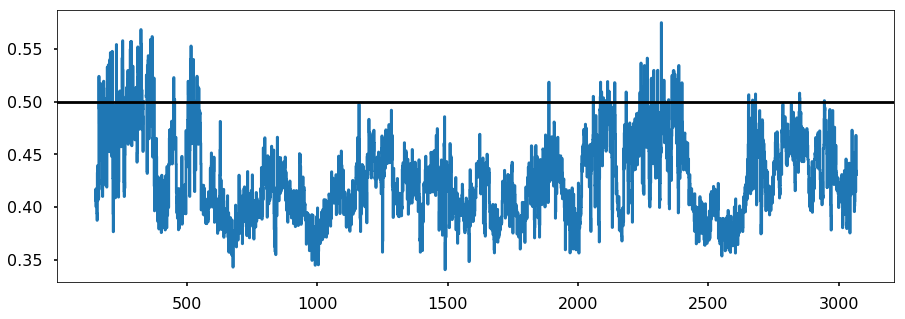

In [111]:
g = vec['U'].groupby('chrom').get_group('chr19')
plt.figure(figsize=(15, 5))
plt.step(np.arange(len(g)), g['E1'], where='post')
plt.axhline(0, c='k')
plt.figure(figsize=(15, 5))
plt.step(np.arange(len(g)), g['GC'], where='post')
plt.axhline(0.5, c='k')

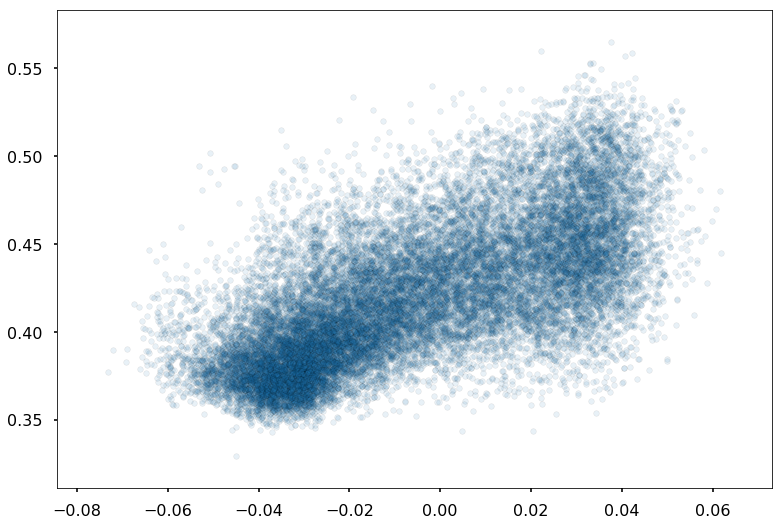

In [112]:
plt.scatter(vecs['E1'], vecs['GC'], marker='.', edgecolor='k', alpha=0.1)

In [14]:
"""
Saddle plot code.

Authors
~~~~~~~
* Anton Goloborodko
* Nezar Abdennur

"""
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import toeplitz
from cytoolz import merge
import numpy as np
import pandas as pd


pal = sns.color_palette('muted')


def digitize_track(
        bins,
        get_track,
        get_mask,
        chromosomes,
        prange=None,
        by_percentile=False):
    """
    Digitize per-chromosome genomic tracks.
    
    Parameters
    ----------
    get_track : function
        A function returning a genomic track given a chromosomal name/index.
    get_mask : function
        A function returning a binary mask of valid genomic bins given a 
        chromosomal name/index.
    chromosomes : list or iterator
        A list of names/indices of all chromosomes.
    bins : int or list or numpy.ndarray
        If list or numpy.ndarray, `bins` must contain the bin edges for 
        digitization.
        If int, then the specified number of bins will be generated 
        automatically from the genome-wide range of the track values.
    prange : pair of floats
        The percentile of the genome-wide range of the track values used to 
        generate bins. E.g., if `prange`=(2. 98) the lower bin would 
        start at the 2-nd percentile and the upper bin would end at the 98-th 
        percentile of the genome-wide signal.
        Use to prevent the extreme track values from exploding the bin range.
        Is ignored if `bins` is a list or a numpy.ndarray.
    by_percentile : bool
        If true then the automatically generated bins will contain an equal 
        number of genomic bins genome-wide (i.e. track values are binned 
        according to their percentile). Otherwise, bins edges are spaced equally. 
        Is ignored if `bins` is a list or a numpy.ndarray.
        
    Returns
    -------
    digitized : dict
        A dictionary of the digitized track, split by chromosome.
        The value of -1 corresponds to the masked genomic bins, the values of 0 
        and the number of bins correspond to the values lying below and above 
        the bin range limits. 
    binedges : numpy.ndarray
        The edges of bins used to digitize the track.
    """
    
    if not hasattr(bins, '__len__'):
        if prange is None:
            prange = (0, 100)

        fulltrack = np.concatenate([
            get_track(chrom)[get_mask(chrom)] 
                for chrom in chromosomes
        ])
        
        if by_percentile:
            perc_edges = np.linspace(prange[0], prange[1], bins + 1)
            binedges = np.percentile(fulltrack, perc_edges)
        else:
            lo = np.percentile(fulltrack, prange[0])
            hi = np.percentile(fulltrack, prange[1])
            binedges = np.linspace(lo, hi, bins + 1)
    else:
        binedges = bins

    digitized = {}
    for chrom in chromosomes:
        x = np.digitize(get_track(chrom), binedges, right=False)        
        x[~get_mask(chrom)] = -1
        digitized[chrom] = x
        
    return digitized, binedges


def fill_diagonal(A, values, k=0, wrap=False, inplace=False):
    """
    Based on numpy.fill_diagonal, but allows for kth diagonals as well.
    Only works on 2D arrays.
    """
    if not inplace:
        A = np.array(A)
    else:
        A = np.asarray(A)
    start = k
    end = None
    step = A.shape[1] + 1
    #This is needed so a tall matrix doesn't have the diagonal wrap around.
    if not wrap:
        end = start + A.shape[1] * A.shape[1]
    A.flat[start:end:step] = values
    return A


def make_saddle(
        get_matrix,
        get_digitized,
        chromosomes,
        contact_type,
        verbose=False):
    """
    Make a matrix of average interaction probabilities between genomic bin pairs
    as a function of a specified genomic track. The provided genomic track must
    be pre-binned (i.e. digitized).
    
    Parameters
    ----------
    get_matrix : function
        A function returning an matrix of interaction between two chromosomes 
        given their names/indicies.
    get_digitized : function
        A function returning a track of the digitized target genomic track given
        a chromosomal name/index.
    chromosomes : list or iterator
        A list of names/indices of all chromosomes.    
    contact_type : str
        If 'cis' then only cis interactions are used to build the matrix.
        If 'trans', only trans interactions are used.
    verbose : bool
        If True then reports progress.

    Returns
    -------
    interaction_sum : 2D array
        The matrix of summed interaction probability between two genomic bins 
        given their values of the provided genomic track.
    interaction_count : 2D array
        The matrix of the number of genomic bin pairs that contributed to the 
        corresponding pixel of ``interaction_sum``.

    """
    if contact_type not in ['cis', 'trans']:
        raise ValueError("The allowed values for the contact_type "
                         "argument are 'cis' or 'trans'.")
    
    n_bins = max([
        get_digitized(chrom).max() 
            for chrom in chromosomes
    ])
    
    interaction_sum   = np.zeros((n_bins, n_bins))
    interaction_count = np.zeros((n_bins, n_bins))
    
    for k, chrom1 in enumerate(chromosomes):
        for chrom2 in chromosomes[k:]:
            if (((contact_type == 'trans') and (chrom1 == chrom2)) or 
                ((contact_type == 'cis') and (chrom1 != chrom2))):
                continue
                
            matrix = get_matrix(chrom1, chrom2)
            for d in [-2, -1, 0, 1, 2]:
                fill_diagonal(matrix, np.nan, d)

            if verbose:
                print('chromosomes {} vs {}'.format(chrom1, chrom2))
                
            for i in range(n_bins):
                row_mask = (get_digitized(chrom1) == i)
                for j in range(n_bins):
                    col_mask = (get_digitized(chrom2) == j)
                    data = matrix[row_mask, :][:, col_mask]
                    data = data[np.isfinite(data)]
                    interaction_sum[i, j]   += np.sum(data)
                    interaction_count[i, j] += float(len(data))

    interaction_sum   += interaction_sum.T
    interaction_count += interaction_count.T
    
    return interaction_sum, interaction_count


def saddleplot(binedges,
                digitized,
                saddledata,
                color,
                cbar_label=None,
                fig_kws=None,
                heatmap_kws=None, 
                margin_kws=None):
    """
    Plot saddle data and signal histograms in the margins.
    
    Parameters
    ----------
    binedges: 1D array
    digitized: dict of chrom to 1D array
    saddledata: 2D array
    color: str
    cbar_label: str
    fig_kws: dict, optional
        Extra keywords to pass to ``figure``.
    heatmap_kws : dict, optional
        Extra keywords to pass to ``imshow`` for saddle heatmap.
    margin_kws : dict, optional
        Extra keywords to pass to ``hist`` for left and top margins.

    """
    n_bins = len(binedges) - 1
    lo, hi = 0, n_bins  #-0.5, n_bins - 1.5

    # Populate kwargs
    fig_kws = merge(
        dict(figsize=(5, 5)),
        fig_kws if fig_kws is not None else {}

    )

    heatmap_kws = merge(
        dict(aspect='auto', 
             cmap='coolwarm', 
             interpolation='none',
             vmin=-1,
             vmax=1),
        heatmap_kws if heatmap_kws is not None else {}, 
    )
    vmin = heatmap_kws['vmin']
    vmax = heatmap_kws['vmax']

    margin_kws = merge(
        dict(bins=n_bins,
             range=(0, len(binedges)),
             histtype='stepfilled',
             edgecolor='k',
             facecolor=color,
             linewidth=1),
        margin_kws if margin_kws is not None else {},
    )

    # layout
    gs = GridSpec(
        nrows=3, 
        ncols=3, 
        width_ratios=[0.2, 1, 0.1], 
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )
    fig = plt.figure(**fig_kws)

    # heatmap
    ax = ax1 = plt.subplot(gs[4])
    img = ax.imshow(np.log10(saddledata), **heatmap_kws)
    plt.xticks(
        np.arange(0, n_bins)[::5],
        ['{:0.4f}'.format(t) 
            for t in ((binedges[1:] + binedges[:-1])/2)[::5]],
        rotation=90,
    )
    plt.yticks([])
    plt.xlim(lo, hi)
    plt.ylim(hi, lo)

    # left margin
    plt.subplot(gs[3])
    plt.hist(np.concatenate(list(digitized.values())), 
             **merge(margin_kws, {'orientation': 'horizontal'}))
    plt.xticks([])
    plt.yticks(
        np.arange(0, n_bins)[::5],
        ['{:0.4f}'.format(t) 
            for t in ((binedges[1:] + binedges[:-1])/2)[::5]],
    )
    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    # top margin
    plt.subplot(gs[1])
    plt.hist(np.concatenate(list(digitized.values())), **margin_kws)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(lo, hi)
    plt.ylim(plt.ylim()[0], plt.ylim()[1])  # correct
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    # colorbar
    plt.subplot(gs[5])
    cb = plt.colorbar(
        img, 
        fraction=0.8, 
        label=cbar_label)
    if vmin is not None and vmax is not None:
        cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
    plt.grid(False)
    plt.axis('off')

    return fig

In [83]:
def fillna(x, value=0):
    x = x.copy()
    x[~np.isfinite(x)] = value
    return x

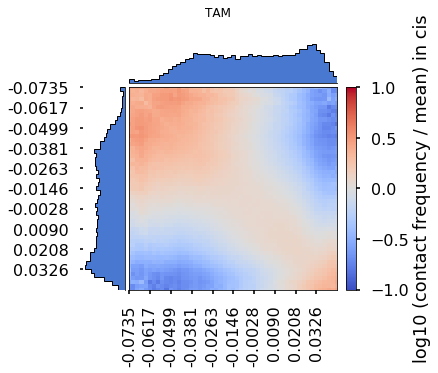

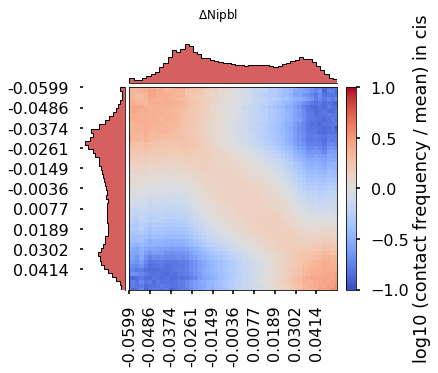

In [19]:
signal_bins = 50

for cond in ['T', 'N']:
    # Create the data "getters"
    get_obsexp = lambda chrom, _: (
        numutils.observedOverExpected(
            clrs[cond].matrix().fetch(chrom))
    )
    get_track = lambda chrom: (
        vec[cond].groupby('chrom').get_group(chrom)['E1']
    )
    get_track_mask = lambda chrom: (
        (vec[cond].groupby('chrom')
              .get_group(chrom)['E1']
              .notnull()) &
        (vec[cond].groupby('chrom')
              .get_group(chrom)['E1'] != 0)
    ).values

    # Bin the track
    digitized, binedges = digitize_track(
        signal_bins,
        get_track,
        get_track_mask,
        chromosomes,
        prange=(0.25, 99.75),
        by_percentile=False
    )

    # Aggregate contacts
    sum_, count = make_saddle(
        get_obsexp, 
        lambda chrom: digitized[chrom],
        chromosomes,
        contact_type='cis',
        verbose=False)
    saddledata = sum_ / count

    # Plotting
    fig = saddleplot(
        binedges,
        digitized,
        saddledata,
        colors[cond],
        cbar_label='log10 (contact frequency / mean) in cis',
        fig_kws=None,
        heatmap_kws=None, 
        margin_kws=None)
    plt.suptitle({
        'U': 'WT',
        'T': 'TAM',
        'N': r'$\Delta$Nipbl'
    }[cond])

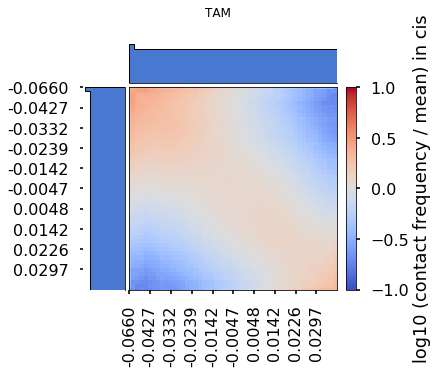

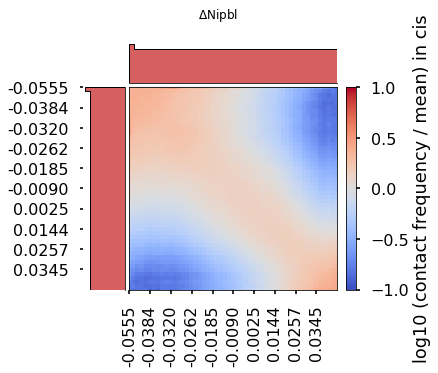

In [29]:
signal_bins = 50

for cond in ['T', 'N']:
    # Create the data "getters"
    get_obsexp = lambda chrom, _: (
        numutils.observedOverExpected(
            clrs[cond].matrix().fetch(chrom))
    )
    get_track = lambda chrom: (
        vec[cond].groupby('chrom').get_group(chrom)['E1']
    )
    get_track_mask = lambda chrom: (
        (vec[cond].groupby('chrom')
              .get_group(chrom)['E1']
              .notnull()) &
        (vec[cond].groupby('chrom')
              .get_group(chrom)['E1'] != 0)
    ).values

    # Bin the track
    digitized, binedges = digitize_track(
        signal_bins,
        get_track,
        get_track_mask,
        chromosomes,
        prange=(0.25, 99.75),
        by_percentile=True
    )

    # Aggregate contacts
    sum_, count = make_saddle(
        get_obsexp, 
        lambda chrom: digitized[chrom],
        chromosomes,
        contact_type='cis',
        verbose=False)
    saddledata = sum_ / count

    # Plotting
    fig = saddleplot(
        binedges,
        digitized,
        saddledata,
        colors[cond],
        cbar_label='log10 (contact frequency / mean) in cis',
        fig_kws=None,
        heatmap_kws=dict(vmin=-1, vmax=1), 
        margin_kws=None)
    plt.suptitle({
        'U': 'WT',
        'T': 'TAM',
        'N': r'$\Delta$Nipbl'
    }[cond])